# Multivariate Linear Regression with Gradient Descent

## Importing Libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/mk-gurucharan/Regression/master/Startups_Data.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## Exploratory Data Analysis

In [4]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [5]:
data.shape

(50, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [7]:
data.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

### Visualizing Dataset

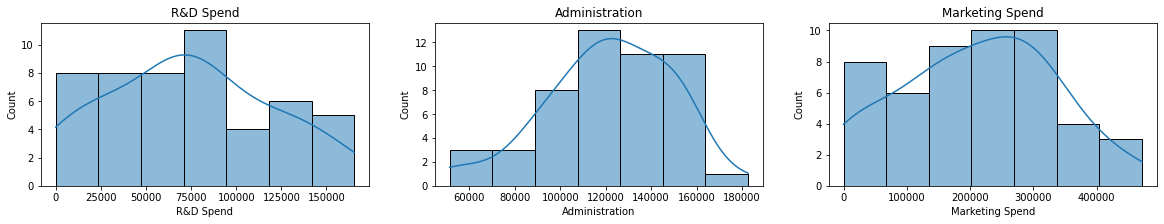

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
sns.histplot(data['R&D Spend'], ax=ax[0], kde=True, legend=False)
ax[0].set_title('R&D Spend')

sns.histplot(data['Administration'], ax=ax[1], kde=True, legend=False)
ax[1].set_title('Administration')

sns.histplot(data['Marketing Spend'], ax=ax[2], kde=True, legend=False)
ax[2].set_title('Marketing Spend')
plt.show()

> Bisa dilihat bahwa datanya tidak memiliki skewness yang begitu berarti, sehingga normalisasi tidak diperlukan

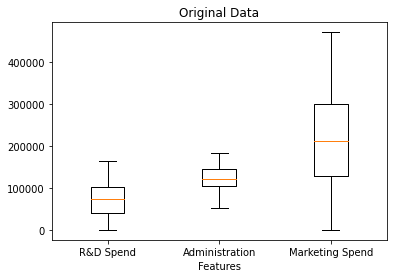

In [9]:
plt.boxplot(data[['R&D Spend','Administration','Marketing Spend']])
plt.title('Original Data')
plt.xlabel('Features')
positions = (1,2,3)
labels = ('R&D Spend','Administration', 'Marketing Spend')
plt.xticks(positions, labels)
plt.show()

> Bisa dilihat, bahwa data ini tidak memiliki outlier, namun bisa kita lebih tingkatkan kebersihan data dengan melakukan standardisasi

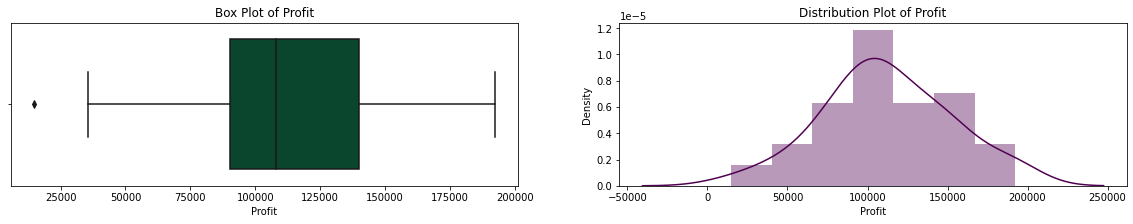

In [10]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.boxplot(data['Profit'],color='#005030')
plt.title('Box Plot of Profit')

plt.subplot(1,2,2)
sns.distplot(a=data['Profit'],color='#500050')
plt.title('Distribution Plot of Profit')
plt.show()

> Di sini terlihat jelas bahwa di Kolom profit, terdapat outlier, sehingga perlu di handle

### Outliers Handling

In [11]:
data[data['Profit'] < 25000]

,R&D Spend,Administration,Marketing Spend,State,Profit
49,0.0,116983.8,45173.06,California,14681.4


> Ini jelas outlier, karena R&D Spend memiliki value 0, perlu kita drop karena data ini tidak masuk akal dalam pembuatan startup.

In [12]:
data.drop(index=49, axis=0, inplace=True)

### Correlation Matrix

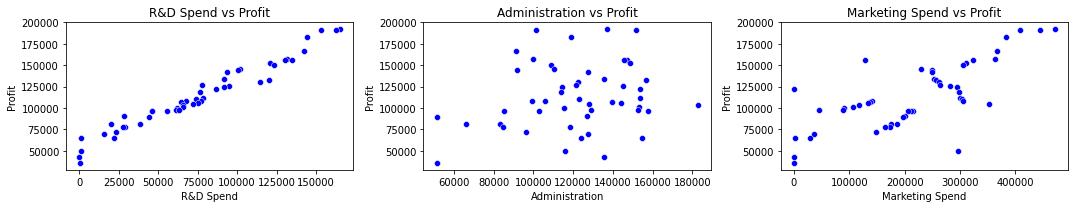

In [13]:
plt.figure(figsize=(20,3))
for i,col in zip(range(1,4),data.columns):
    plt.subplot(1,4,i)
    sns.scatterplot(x=col,y='Profit',data=data,color='blue')
    plt.title(f"{col} vs Profit")
    plt.tight_layout()

> Bisa dilihat bahwa hanya R&D Spend yang memiliki korelasi kuat dengan profit, tapi akan kita perkuat dengan matrix korelasi

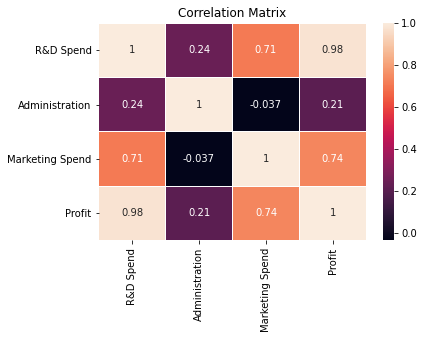

In [14]:
plt.title("Correlation Matrix")
sns.heatmap(data=data.corr(), annot=True, linewidth=0.1)
plt.show()

> Bisa dilihat bahwa korelasi R&D Spend terbukti kuat dengan profit, nah di sini, Administration punya korelasi kuat dengan profit, namun feature ini juga punya korelasi kuat dengan Marketing Spend, sehingga perlu di handle.

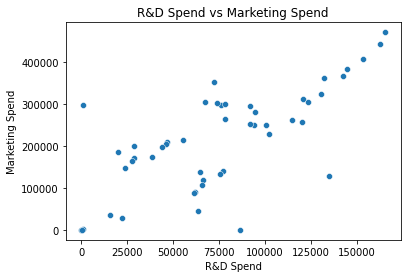

In [15]:
sns.scatterplot(data=data,x='R&D Spend',y='Marketing Spend')
plt.title("R&D Spend vs Marketing Spend")
plt.show()

> Di sini bisa dilihat bahwa korelasinya cukup kuat (hubungan linear). Untuk mencegah Multicolinearity (Independet Variable dipengaruhi oleh independent lainnya), maka kita perlu drop kolom ini.

### Wrangle Data

In [16]:
data = data.drop(['Marketing Spend', 'Administration'], axis=1)
data.head()

,R&D Spend,State,Profit
0,165349.20,New York,192261.83
1,162597.70,California,191792.06
2,153441.51,Florida,191050.39
3,144372.41,New York,182901.99
4,142107.34,Florida,166187.94


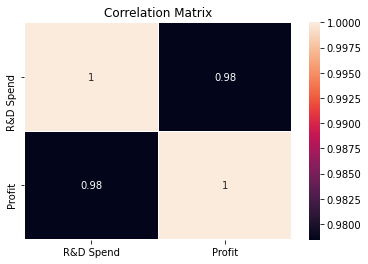

In [17]:
plt.title("Correlation Matrix")
sns.heatmap(data=data.corr(), annot=True, linewidth=0.1)
plt.show()

#### Handling Categorical Columns

In [18]:
data['State'].unique()

array(['New York', 'California', 'Florida'], dtype=object)

In [19]:
data.groupby('State')['State'].count()

State
California    16
Florida       16
New York      17
Name: State, dtype: int64

In [20]:
# Kita akan melakukan proses one hot encoding (di sini memakai dummy variable) untuk mengkategorikan State
data = pd.get_dummies(data=data)
data.head()

,R&D Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,192261.83,0,0,1
1,162597.70,191792.06,1,0,0
2,153441.51,191050.39,0,1,0
3,144372.41,182901.99,0,0,1
4,142107.34,166187.94,0,1,0


> Untuk mencegah Dummy Variable Trap, atau secara definisi bahwa 1 kategori dipengaruhi oleh kategori lainnya, misal apabila ada row yang tidak termasuk florida ataupun new york, sudah pasti itu california. Dari sini, kita perlu drop salah satu kolom, misal State_Florida

In [21]:
data = data.drop(labels=['State_Florida'], axis=1)
data.head()

,R&D Spend,Profit,State_California,State_New York
0,165349.20,192261.83,0,1
1,162597.70,191792.06,1,0
2,153441.51,191050.39,0,0
3,144372.41,182901.99,0,1
4,142107.34,166187.94,0,0


## Splitting Dataset

In [22]:
X = data[['R&D Spend', 'State_California', 'State_New York']]
Y = data['Profit']

### Standardizing Data

In [23]:
sc = StandardScaler()
X = sc.fit_transform(X)

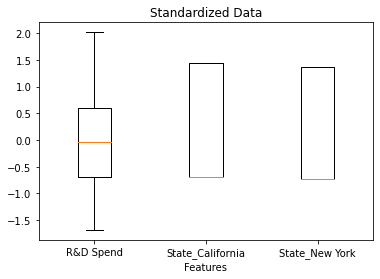

In [24]:
plt.boxplot(X)
plt.title('Standardized Data')
plt.xlabel('Features')
positions = (1,2,3)
labels = ('R&D Spend','State_California', 'State_New York')
plt.xticks(positions, labels)
plt.show()

In [25]:
X_train = X[0:39]
X_test = X[39:]
y_train = Y[0:39]
y_test = Y[39:]

In [26]:
print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (39, 3)
Shape of X_test = (10, 3)
Shape of y_train = (39,)
Shape of y_test = (10,)


## Modelling

In [62]:
def y_predict(weight, X, intercept):
    predicted_list = []
    for i in range(len(X)):
        predicted_list.append(np.dot(weight,X[i])+intercept)
    return np.array(predicted_list)

def MSE_loss_function(Y, Y_pred):
    length = len(Y)
    sum_value = 0
    for i in range(length):
        sum_value += (Y[i] - Y_pred[i])**2
    return (1/length)*sum_value

def derivative_weight(X, Y, Y_pred):
    length = len(Y)
    sum_value = 0
    for i in range(length):
        sum_value += (-X[i]*(Y[i] - Y_pred[i]))
    return (2/length)*sum_value

def derivative_bias(Y, Y_pred):
    length = len(Y)
    sum_value = 0
    for i in range(length):
        sum_value += (-(Y[i]-Y_pred[i]))
    return (2/length)*sum_value

def Gradient_Descent(X, Y):
    weight = np.random.randn(X.shape[1])
    intercept = 0
    epochs = 8000
    learning_rate = 0.002
    loss = []

    for _ in range(epochs):
        Y_pred = y_predict(weight, X, intercept)
        weight = weight - learning_rate * derivative_weight(X, Y, Y_pred)
        intercept = intercept - learning_rate * derivative_bias(Y, Y_pred)
        loss.append(MSE_loss_function(Y, Y_pred))
    
    # Plotting loss over epochs
    plt.plot(np.arange(1, epochs), loss[1:])
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")

    return weight, intercept


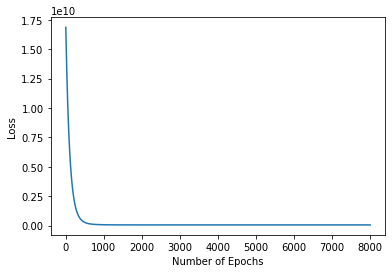

In [63]:
W, B= Gradient_Descent(X_train,y_train)

> Dapat dilihat, bahwa dengan metode **Gradient Descent**, model ini mampu meningkatkan performa model dengan baik

In [64]:
print(f'Weight : {W}')
print(f'Bias : {B}')

Weight : [35949.99367775  1054.71303941  -761.20735814]
Bias : 114798.03867354809


## Predict with the Model

In [65]:
def prediction(X_input):
    list = []
    for i in range(len(X_input)):
        list.append(np.dot(W,X_input[i]) + B)
    return np.array(list)

In [66]:
test_pred = prediction(X_test)

## Comparing Ground Truth and Prediction

In [67]:
y_test = y_test.reset_index(drop=True)
dataFrame_prediction = pd.DataFrame({
    'Ground Truth' : y_test,
    'Prediction' : np.round(test_pred, 2)
})

dataFrame_prediction

,Ground Truth,Prediction
0,81005.76,87346.19
1,78239.91,79452.77
2,77798.83,76510.12
3,71498.49,75335.93
4,69758.98,64937.91
5,65200.33,74157.91
6,64926.08,53259.42
7,49490.75,55112.40
8,42559.73,56302.44
9,35673.41,52890.54


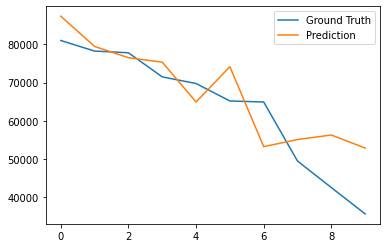

In [68]:
plt.plot(np.arange(0,10), dataFrame_prediction['Ground Truth'], label='Ground Truth')
plt.plot(np.arange(0,10), dataFrame_prediction['Prediction'], label = 'Prediction')
plt.legend()
plt.show()

## Mean Squared Error Value Using This Model

In [69]:
MSE_loss_function(y_test, test_pred)

81454524.57958251